In [0]:
# imports dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import math

In [0]:
data=pd.read_csv('interview_dataset.csv',skiprows=[1])
data["datetime"]=pd.to_datetime(data["datetime"],errors='coerce')
data = data.set_index(['datetime'])

In [3]:
# Replaces USAGE_KWH values below 5 with nans and then linear interpolates them, necessary for boxcox transformation
weird = []
index = 0
for item in data.iloc[:,0]:
    index+=1
    if item>=0 and item<5:
        print(str(item)+" the index is " + str(index))
        weird.append(index-1)
for item in weird:
    data.iloc[item,0] = np.nan
    print(data.iloc[item,0])
    
data.iloc[:,0] = data.iloc[:,0].interpolate(method='linear')
print(sum(np.isnan(x) for x in data.iloc[:,0]))

1.133 the index is 17249
0.0 the index is 17250
0.0 the index is 17251
0.0 the index is 17252
0.0 the index is 17253
0.0 the index is 17254
0.0 the index is 17255
0.0 the index is 28778
0.0 the index is 28779
nan
nan
nan
nan
nan
nan
nan
nan
nan
0


In [4]:
# Replaces all nan values in the dataset with linear interpolation values, necessary for LSTM
for num in range(data.shape[1]):
    data.iloc[:,num] = data.iloc[:,num].interpolate(method='linear')
    print(sum(np.isnan(x) for x in data.iloc[:,num]))

0
0
0
0
0
0
0


In [0]:
from pandas import DataFrame, concat
# convert series to supervised learning (creating input data using data from previous timestamps and output data from future timestamps)
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

from sklearn.preprocessing import MinMaxScaler

# frame as supervised learning (use 100 previous rows as input and predict 96 future rows)
reframed = series_to_supervised(data.values, 100, 96)
# drop columns we don't want to predict (drop all output values except for the 96 USAGE_KWH values)
no_pred = []
for out in range(96):
    for var in range(6):
        no_pred.append(701+var+out*7)
reframed.drop(reframed.columns[no_pred], axis=1, inplace=True)
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed)

In [0]:
# split into train and test sets (test on last 196 rows. Note: in the code, only the last 196th to 96th rows were used for testing, with valid results regardless)
values = scaled
n_train_hours = len(values)-96-100
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [33]:
# train_X values are all train rows, and all column values until the last 96, which are the 96 predicted USAGE_KWH values. train_y contains all rows, and last 96 columns
# test_X contains all but last 96 rows (this was an unecessary effort to reducing test data size-  there was no particular reason for doing this; the results are valid regardless) and all but last 96 columns.
train_X, train_y = train[:, :-96], train[:, -96:]
test_X, test_y = test[:-96, :-96], test[:-96, -96:]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(34744, 1, 700) (34744, 96) (100, 1, 700) (100, 96)


In [36]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
# modelcheckpoint is a way to save the lowest validation loss value during training
checkpoint = ModelCheckpoint('LSTM_100lag.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  


# design network
model = Sequential()
model.add(LSTM(700, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(96))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=int(train.shape[0]/96), validation_data=(test_X, test_y), verbose=1, shuffle=False, callbacks=[checkpoint])

Train on 34744 samples, validate on 100 samples
Epoch 1/50
34744/34744 [==============================] - 3s 83us/step - loss: 0.0123 - val_loss: 0.0043

Epoch 00001: val_loss improved from inf to 0.00434, saving model to LSTM_50lag.h5
Epoch 2/50
34744/34744 [==============================] - 1s 35us/step - loss: 0.0094 - val_loss: 0.0044

Epoch 00002: val_loss did not improve from 0.00434
Epoch 3/50
34744/34744 [==============================] - 1s 34us/step - loss: 0.0084 - val_loss: 0.0043

Epoch 00003: val_loss improved from 0.00434 to 0.00432, saving model to LSTM_50lag.h5
Epoch 4/50
34744/34744 [==============================] - 1s 35us/step - loss: 0.0078 - val_loss: 0.0043

Epoch 00004: val_loss improved from 0.00432 to 0.00425, saving model to LSTM_50lag.h5
Epoch 5/50
34744/34744 [==============================] - 1s 36us/step - loss: 0.0073 - val_loss: 0.0040

Epoch 00005: val_loss improved from 0.00425 to 0.00402, saving model to LSTM_50lag.h5
Epoch 6/50
34744/34744 [=======

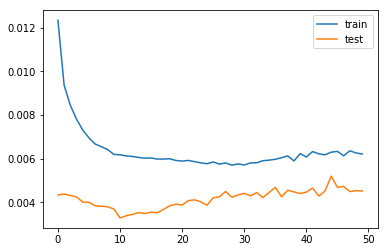

In [37]:
from matplotlib import pyplot
# plot training history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [38]:
# load the optimum model and evaluate performance using MSE
from numpy import concatenate
from sklearn.metrics import mean_squared_error
from keras.models import load_model

model = load_model('LSTM_100lag.h5')
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:,-700:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:96]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 96))
inv_y = concatenate((test_y, test_X[:, -700:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:96]
# calculate MSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)

Test MSE: 8.363


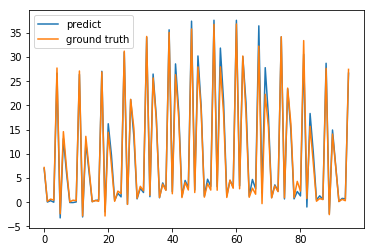

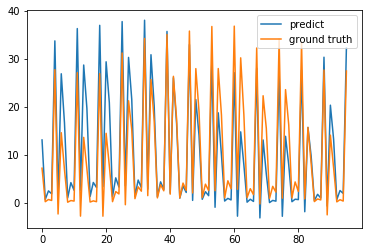

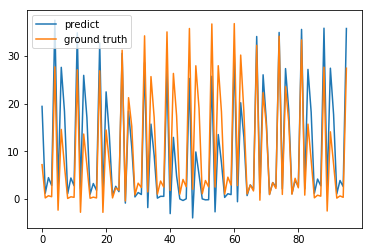

In [43]:
# plotting 3 randomly selected rows (off 100) from test dataset to visualize predictions versus ground truth.
pyplot.figure()
pyplot.plot(inv_yhat[0,:], label='predict')
pyplot.plot(inv_y[0,:], label='ground truth')
pyplot.legend()
pyplot.show()

pyplot.figure()
pyplot.plot(inv_yhat[30,:], label='predict')
pyplot.plot(inv_y[0,:], label='ground truth')
pyplot.legend()
pyplot.show()

pyplot.figure()
pyplot.plot(inv_yhat[60,:], label='predict')
pyplot.plot(inv_y[0,:], label='ground truth')
pyplot.legend()
pyplot.show()